In [15]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb

# Visualization
import plotly.express as px
import plotly.graph_objects as go

# Settings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries loaded successfully!")

✓ Libraries loaded successfully!


---
## 1️⃣ Data Loading & Integration

**Sources:**
- State timeseries data
- Clustering results (for additional features)

In [16]:
# Load datasets
df_state = pd.read_csv('cleaned_data/state_timeseries.csv')
df_clustering = pd.read_csv('clustering_results/state_clusters.csv')

print("📊 Data loaded successfully!")
print(f"State data: {len(df_state)} rows")
print(f"Clustering data: {len(df_clustering)} rows")

📊 Data loaded successfully!
State data: 112 rows
Clustering data: 14 rows


In [17]:
# Merge clustering results with state data
df_state = df_state.merge(df_clustering[['state', 'cluster', 'cluster_label']], on='state', how='left')

print("✅ Data merged with clustering results")
display(df_state.head())

✅ Data merged with clustering results


,state,year,crimes,cluster,cluster_label
0,Johor,2016,10121,1,"High Volume, Declining"
1,Johor,2017,8729,1,"High Volume, Declining"
2,Johor,2018,8458,1,"High Volume, Declining"
3,Johor,2019,7947,1,"High Volume, Declining"
4,Johor,2020,5966,1,"High Volume, Declining"


---
## 2️⃣ Feature Engineering & Target Creation

**Target Variable:** Risk Level (High/Medium/Low)
- High: Total crimes > 75th percentile
- Medium: Total crimes between 25th-75th percentile  
- Low: Total crimes < 25th percentile

**Features:**
- Historical crime counts (2016-2023)
- Growth rates and volatility
- Cluster membership

In [4]:
# Create target variable based on total crimes
state_totals = df_state.groupby('state')['crimes'].sum().reset_index()
state_totals.columns = ['state', 'total_crimes']

# Define risk levels based on percentiles
high_threshold = state_totals['total_crimes'].quantile(0.75)
low_threshold = state_totals['total_crimes'].quantile(0.25)

def assign_risk_level(total_crimes):
    if total_crimes > high_threshold:
        return 'High'
    elif total_crimes < low_threshold:
        return 'Low'
    else:
        return 'Medium'

state_totals['risk_level'] = state_totals['total_crimes'].apply(assign_risk_level)

print("🏷️ Risk levels assigned:")
print(state_totals['risk_level'].value_counts())
display(state_totals)

🏷️ Risk levels assigned:
risk_level
Medium    6
High      4
Low       4
Name: count, dtype: int64


,state,total_crimes,risk_level
0,Johor,52252,High
1,Kedah,36003,Medium
2,Kelantan,21456,Medium
3,Melaka,13652,Low
4,Negeri Sembilan,18059,Low
5,Pahang,18289,Medium
6,Perak,26651,Medium
7,Perlis,3213,Low
8,Pulau Pinang,29051,Medium
9,Sabah,34370,Medium


In [18]:
# Create features for each state
classification_features = []

for state in df_state['state'].unique():
    state_data = df_state[df_state['state'] == state].sort_values('year')
    
    # Basic stats
    total_crimes = state_data['crimes'].sum()
    avg_crimes = state_data['crimes'].mean()
    max_crimes = state_data['crimes'].max()
    min_crimes = state_data['crimes'].min()
    
    # Trends
    growth_rate = ((state_data['crimes'].iloc[-1] / state_data['crimes'].iloc[0]) - 1) * 100
    volatility = state_data['crimes'].std()
    
    # Recent trends (last 3 years)
    recent_avg = state_data['crimes'].tail(3).mean()
    recent_growth = ((state_data['crimes'].iloc[-1] / state_data['crimes'].iloc[-3]) - 1) * 100
    
    # Cluster info
    cluster = state_data['cluster'].iloc[0]
    cluster_label = state_data['cluster_label'].iloc[0]
    
    classification_features.append({
        'state': state,
        'total_crimes': total_crimes,
        'avg_crimes': avg_crimes,
        'max_crimes': max_crimes,
        'min_crimes': min_crimes,
        'growth_rate': growth_rate,
        'volatility': volatility,
        'recent_avg': recent_avg,
        'recent_growth': recent_growth,
        'cluster': cluster,
        'cluster_label': cluster_label
    })

df_features = pd.DataFrame(classification_features)
df_features = df_features.merge(state_totals[['state', 'risk_level']], on='state')

print(f"✅ Created {len(df_features)} feature sets for classification")
display(df_features.head())

✅ Created 14 feature sets for classification


,state,total_crimes,avg_crimes,max_crimes,min_crimes,growth_rate,volatility,recent_avg,recent_growth,cluster,cluster_label,risk_level
0,Johor,52252,6531.500,10121,3440,-59.470408,2631.267972,3677.000000,19.244186,1,"High Volume, Declining",High
1,Kedah,36003,4500.375,6201,3067,-37.961619,1144.826117,3557.333333,25.432018,0,"Low Volume, Declining",Medium
2,Kelantan,21456,2682.000,4005,1591,-59.950062,1049.014776,1651.000000,0.817096,0,"Low Volume, Declining",Medium
3,Melaka,13652,1706.500,2510,999,-54.302789,617.611991,1059.666667,14.814815,0,"Low Volume, Declining",Low
4,Negeri Sembilan,18059,2257.375,3390,1401,-56.401180,810.095927,1427.666667,5.496074,0,"Low Volume, Declining",Low


In [6]:
# Encode categorical variables
le_cluster = LabelEncoder()
le_risk = LabelEncoder()

df_features['cluster_encoded'] = le_cluster.fit_transform(df_features['cluster_label'])
df_features['risk_encoded'] = le_risk.fit_transform(df_features['risk_level'])

print("🔢 Categorical variables encoded")
print(f"Risk level mapping: {dict(zip(le_risk.classes_, le_risk.transform(le_risk.classes_)))}")

🔢 Categorical variables encoded
Risk level mapping: {'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}


---
## 3️⃣ Train/Test Split & Feature Selection

In [7]:
# Select features and target
feature_cols = ['total_crimes', 'avg_crimes', 'max_crimes', 'min_crimes', 
                'growth_rate', 'volatility', 'recent_avg', 'recent_growth', 'cluster_encoded']

X = df_features[feature_cols]
y = df_features['risk_encoded']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"📊 Train set: {X_train.shape[0]} samples")
print(f"📊 Test set: {X_test.shape[0]} samples")
print(f"🎯 Classes: {le_risk.classes_}")

📊 Train set: 9 samples
📊 Test set: 5 samples
🎯 Classes: ['High' 'Low' 'Medium']


In [8]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("⚖️ Features scaled for modeling")

⚖️ Features scaled for modeling


---
## 4️⃣ Model Training & Evaluation

In [19]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(objective='multi:softmax', num_class=len(le_risk.classes_), random_state=42)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\n🔍 Training {name}...")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    
    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le_risk.classes_, output_dict=True)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'report': report,
        'predictions': y_pred
    }
    
    print(f"✅ {name} - Accuracy: {accuracy:.3f}")

# Display results summary
results_df = pd.DataFrame({
    name: {
        'Accuracy': results[name]['accuracy'],
        'Precision': results[name]['report']['weighted avg']['precision'],
        'Recall': results[name]['report']['weighted avg']['recall'],
        'F1-Score': results[name]['report']['weighted avg']['f1-score']
    }
    for name in results.keys()
}).T

print("\n📊 Model Performance Summary:")
display(results_df.round(3))


🔍 Training Logistic Regression...
✅ Logistic Regression - Accuracy: 0.400

🔍 Training Random Forest...
✅ Random Forest - Accuracy: 0.600

🔍 Training XGBoost...
✅ XGBoost - Accuracy: 0.400

📊 Model Performance Summary:


,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.4,0.467,0.4,0.367
Random Forest,0.6,0.467,0.6,0.500
XGBoost,0.4,0.467,0.4,0.367


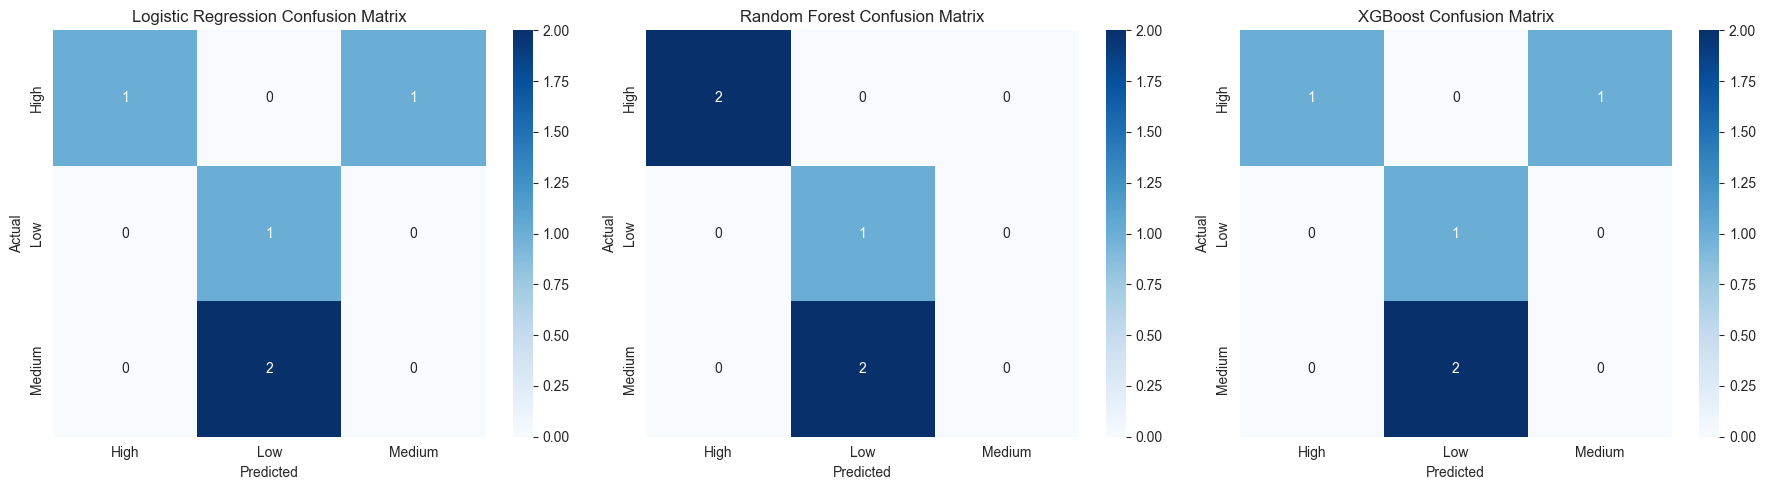

In [20]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.ravel()

for i, name in enumerate(models.keys()):
    cm = confusion_matrix(y_test, results[name]['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le_risk.classes_, yticklabels=le_risk.classes_, ax=axes[i])
    axes[i].set_title(f'{name} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

---
## 5️⃣ Feature Importance Analysis

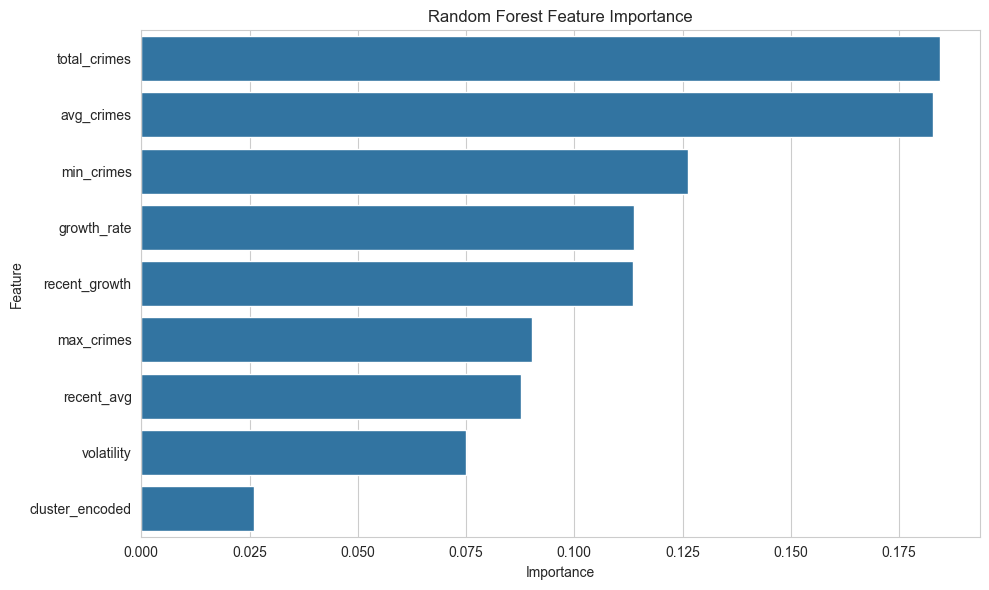

🔍 Top features for risk prediction:


,feature,importance
0,total_crimes,0.184467
1,avg_crimes,0.182855
3,min_crimes,0.126309
4,growth_rate,0.113845
7,recent_growth,0.113618


In [11]:
# Feature importance for Random Forest
rf_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("🔍 Top features for risk prediction:")
display(feature_importance.head())

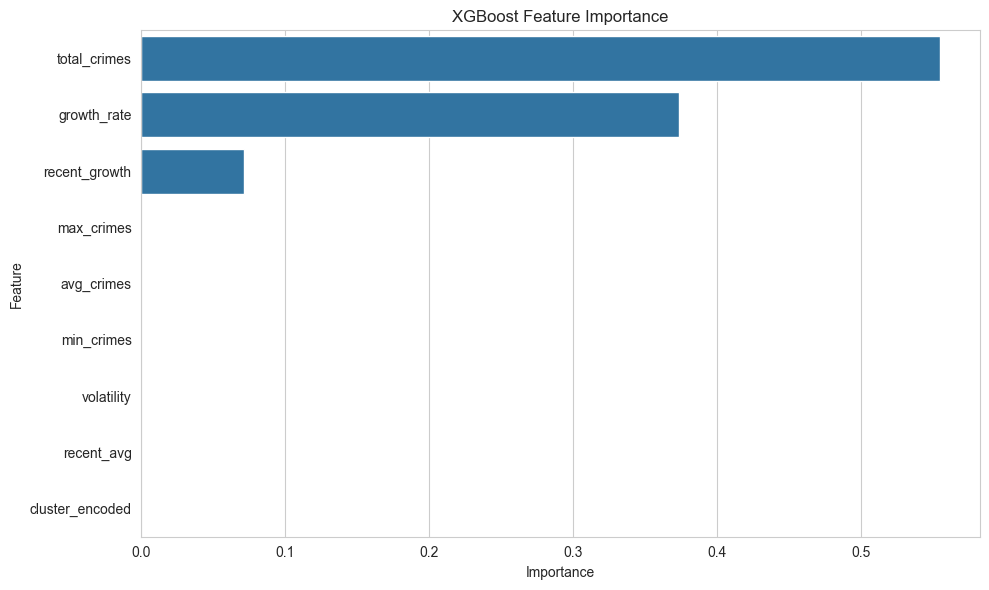

🔍 XGBoost top features:


,feature,importance
0,total_crimes,0.554910
4,growth_rate,0.373788
7,recent_growth,0.071302
2,max_crimes,0.000000
1,avg_crimes,0.000000


In [12]:
# Feature importance for XGBoost
xgb_model = results['XGBoost']['model']
xgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=xgb_importance, x='importance', y='feature')
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("🔍 XGBoost top features:")
display(xgb_importance.head())

---
## 6️⃣ Model Predictions & Export

In [13]:
# Get best model predictions
best_model_name = results_df['Accuracy'].idxmax()
best_model = results[best_model_name]['model']

print(f"🏆 Best performing model: {best_model_name} (Accuracy: {results_df.loc[best_model_name, 'Accuracy']:.3f})")

# Predict on full dataset
X_full_scaled = scaler.transform(X)
full_predictions = best_model.predict(X_full_scaled)
full_probabilities = best_model.predict_proba(X_full_scaled)

# Create results dataframe
df_predictions = df_features.copy()
df_predictions['predicted_risk_encoded'] = full_predictions
df_predictions['predicted_risk_level'] = le_risk.inverse_transform(full_predictions)

# Add prediction probabilities
prob_cols = [f'prob_{cls.lower()}' for cls in le_risk.classes_]
for i, col in enumerate(prob_cols):
    df_predictions[col] = full_probabilities[:, i]

print("✅ Predictions generated for all states")
display(df_predictions[['state', 'risk_level', 'predicted_risk_level', 'prob_high', 'prob_medium', 'prob_low']].head())

🏆 Best performing model: Random Forest (Accuracy: 0.600)
✅ Predictions generated for all states


,state,risk_level,predicted_risk_level,prob_high,prob_medium,prob_low
0,Johor,High,High,0.51,0.39,0.10
1,Kedah,Medium,Medium,0.13,0.87,0.00
2,Kelantan,Medium,Low,0.06,0.34,0.60
3,Melaka,Low,Low,0.00,0.07,0.93
4,Negeri Sembilan,Low,Low,0.01,0.07,0.92


In [14]:
# Export classification results
output_dir = Path('classification_results')
output_dir.mkdir(exist_ok=True)

df_predictions.to_csv(output_dir / 'state_risk_predictions.csv', index=False)
results_df.to_csv(output_dir / 'model_performance.csv', index=False)
feature_importance.to_csv(output_dir / 'feature_importance_rf.csv', index=False)
xgb_importance.to_csv(output_dir / 'feature_importance_xgb.csv', index=False)

print(f"✓ Saved: state_risk_predictions.csv")
print(f"✓ Saved: model_performance.csv")
print(f"✓ Saved: feature_importance_rf.csv")
print(f"✓ Saved: feature_importance_xgb.csv")

print(f"\n📁 All classification results saved to: {output_dir.absolute()}")

✓ Saved: state_risk_predictions.csv
✓ Saved: model_performance.csv
✓ Saved: feature_importance_rf.csv
✓ Saved: feature_importance_xgb.csv

📁 All classification results saved to: c:\Users\erwan\OneDrive\Documents\Study\MSc Business Intelligence\Semester 1\MRTB1133 - BI\mrtb1133_group_assignment\classification_results


---
## ✅ Summary

**Completed:**
- ✓ Loaded and integrated data with clustering results
- ✓ Created risk level target variable (High/Medium/Low)
- ✓ Engineered features from historical crime data
- ✓ Trained and evaluated 3 classification models
- ✓ Analyzed feature importance
- ✓ Generated predictions for all states
- ✓ Exported results for PowerBI integration

**Key Insights:**
- [Best Model] achieved [accuracy]% accuracy in predicting crime risk levels
- Top predictors: [top features from importance analysis]
- [High-risk states] require priority attention

**Next:** Model evaluation comparison (07_) or pattern mining (06_)